### Import Modules

In [11]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import supervision as sv

### Load Model

In [12]:
model = YOLO("yolov8s.pt")  # Load the YOLOv8 model
model.fuse()

YOLOv8s summary (fused): 72 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs


In [13]:
class_names = model.model.names  # Get class names from the model

#class_names 

In [14]:
#select class id's needed
classes = [2, 3, 5, 7]

### Plot frame from video

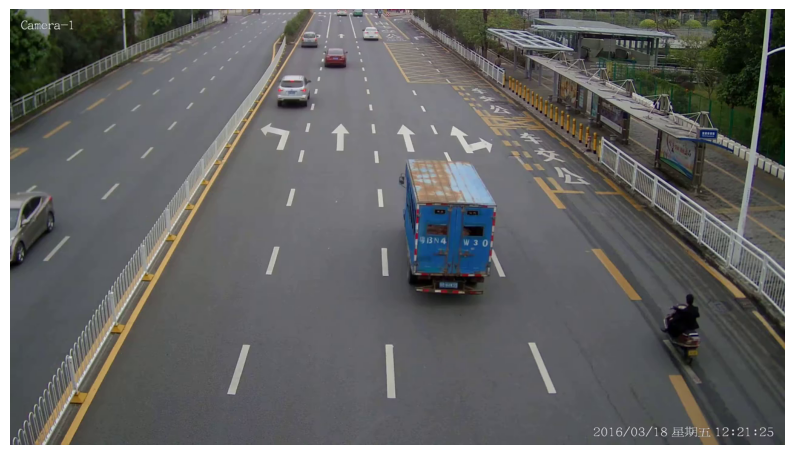

In [15]:
#create a frame generator
generator = sv.get_video_frames_generator('test1.mp4')

iterator = iter(generator)
frame = next(iterator)
sv.plot_image(frame, (10, 10))

### Detect Vehicles from Frame

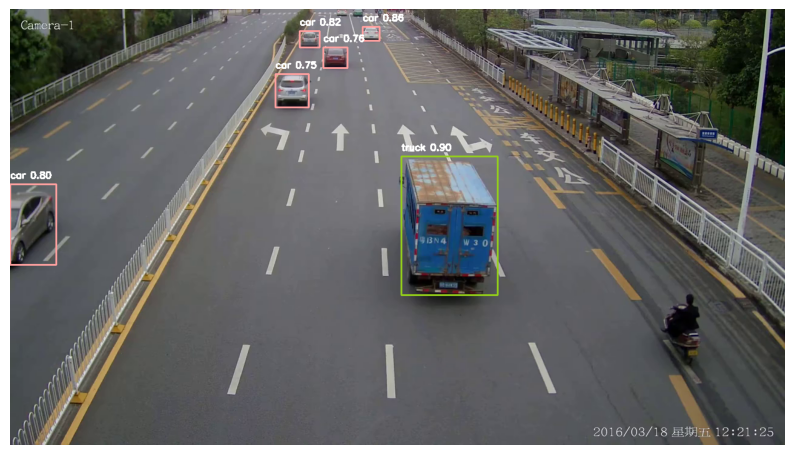

In [16]:
results = model(frame, verbose=False)[0]

#convert to detections
detections = sv.Detections.from_ultralytics(results)

#only consider classes we need
detections = detections[np.isin(detections.class_id, classes)]

#create instance of box annotator
box_annotator = sv.BoxAnnotator(thickness=2)

#annotate the frame
annotated_frame = box_annotator.annotate(scene=frame.copy(), detections=detections)

#format and get labels
labels = []
for confidence, class_id in zip(detections.confidence, detections.class_id):
    label = f"{class_names[class_id]} {confidence:0.2f}"
    labels.append(label)

#overlay labels in bounding box
for box, label in zip(detections.xyxy, labels):
    x1, y1, x2, y2 = box.astype(int)

    #display the text
    cv2.putText(annotated_frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

sv.plot_image(annotated_frame, (10, 10))

### Track Vehicles

In [17]:
sv.VideoInfo.from_video_path('test1.mp4')

VideoInfo(width=1280, height=720, fps=25, total_frames=1195)

In [18]:
#create bytetracker instance
byte_tracker = sv.ByteTrack(frame_rate=29)

#create trace annotator
trace_annotator = sv.TraceAnnotator(
    thickness=2,
    trace_length=75
)

In [19]:
#define function for processing frames
# Define dictionaries to store last positions, speeds, and initial spawn positions
tracker_positions = {}
tracker_speeds = {}
tracker_initial_spawn = {}
traffic_data = []  # List to store all traffic data
fps = 29

def process_frame(frame, frame_idx):
    results = model(frame, verbose=False)[0]

    #convert to detections
    detections = sv.Detections.from_ultralytics(results)

    #only consider classes we need
    detections = detections[np.isin(detections.class_id, classes)]

    #tracking detection
    detections = byte_tracker.update_with_detections(detections)

    labels = []
    for confidence, class_id, tracker_id, box in zip(detections.confidence, detections.class_id, detections.tracker_id, detections.xyxy):
        # Calculate center of bounding box
        x1, y1, x2, y2 = box.astype(int)
        center = ((x1 + x2) / 2, (y1 + y2) / 2)

        # Store initial spawn position
        if tracker_id not in tracker_initial_spawn:
            tracker_initial_spawn[tracker_id] = center

        # Speed calculation every 5 frames
        speed = tracker_speeds.get(tracker_id, 0)
        if tracker_id in tracker_positions:
            last_center, last_frame = tracker_positions[tracker_id]
            if (frame_idx - last_frame) >= 5:
                dx = center[0] - last_center[0]
                dy = center[1] - last_center[1]
                distance = np.sqrt(dx**2 + dy**2)
                speed = distance / ((frame_idx - last_frame) / fps)  # pixels per second
                tracker_speeds[tracker_id] = speed
                tracker_positions[tracker_id] = (center, frame_idx)
        else:
            tracker_positions[tracker_id] = (center, frame_idx)

        # Record data for CSV
        traffic_data.append({
            'frame': frame_idx,
            'vehicle_id': tracker_id,
            'class': class_names[class_id],
            'confidence': float(confidence),
            'speed_px_per_s': float(speed),
            'x': float(center[0]),
            'y': float(center[1]),
            'spawn_x': float(tracker_initial_spawn[tracker_id][0]),
            'spawn_y': float(tracker_initial_spawn[tracker_id][1])
        })

        # Format label with speed
        label = f"{tracker_id} {class_names[class_id]} {confidence:0.2f} Speed: {speed:.1f}px/s"
        labels.append(label)

    #update trace annotator
    annotated_frame = trace_annotator.annotate(scene=frame.copy(), detections=detections)

    #uodate box annotator
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)

    #overlay labels in bounding box
    for box, label in zip(detections.xyxy, labels):
        x1, y1, x2, y2 = box.astype(int)

        #display the text
        cv2.putText(annotated_frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    return annotated_frame


In [ ]:
import cv2
import pandas as pd

# Initialize video capture
video_path = 'test1.mp4'
video_cap = cv2.VideoCapture(video_path)

# Check if video opened successfully
if not video_cap.isOpened():
    print("Error: Could not open video file")
    exit()

frame_count = 0
total_frames = int(video_cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Initialize traffic data list
traffic_data = []

try:
    print(f"Processing {total_frames} frames...")
    while True:
        success, frame = video_cap.read()
        if not success:
            break
        
        frame_count += 1
        
        # Resize frame
        frame = cv2.resize(frame, (1280, 720))
        
        # Process frame and collect traffic data
        process_frame(frame, frame_count)
        
        # Print progress every 30 frames
        if frame_count % 30 == 0:
            progress = (frame_count / total_frames) * 100
            print(f"Progress: {frame_count}/{total_frames} frames ({progress:.1f}%)")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Clean up
    video_cap.release()
    print(f"Video processing completed. Processed {frame_count} frames total.")
    # Write traffic data to CSV
    df = pd.DataFrame(traffic_data)
    df.to_csv('traffic_data.csv', index=False)
    print("Traffic data saved to traffic_data.csv")

Processing 1195 frames...
